# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [124]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, from_unixtime, split, min, max, round, lit
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType #, DateType, TimestampType
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [27]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [37]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()
data.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

### Dataset size, schema & column description

In [38]:
# Dataset size
print(f'Row count: {original_count}')
print(f'Column count: {len(data.columns)}')

Row count: 286500
Column count: 18


In [39]:
# Schema
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



<p style="color:red">TODO: column description</p>

### Duplicate rows

In [7]:
# Any duplicate rows? - No
print(f'Duplicate rows: {data.count() - data.dropDuplicates().count()}')

Duplicate rows: 0


### Missing values

In [8]:
# Filter by missing value (either null of empty - if string)
def filter_missing(data, name):
    return data.where((col(name).isNull()) | (col(name) == ''))

# Show count of missing values for all columns in the dataset
def show_missing(data):
    for field in data.schema:
        print(f'{field.name}: {filter_missing(data, field.name).count()}')
        
        
show_missing(data)

artist: 58392
auth: 0
firstName: 8346
gender: 8346
itemInSession: 0
lastName: 8346
length: 58392
level: 0
location: 8346
method: 0
page: 0
registration: 8346
sessionId: 0
song: 58392
status: 0
ts: 0
userAgent: 8346
userId: 8346


In [9]:
# Are 8346 missing values in user's column firstName, gender, lastName, location, registration, userAgent, userId correlated 
# occurring in the same rows? - Yes

class Missing:
    missing_data = None
    
    def __init__(self, data):
        self.missing_data = data
        
    def filter_missing(self, name):
        self.missing_data = filter_missing(data, name) 
        return self  
    
m = Missing(data) \
    .filter_missing('userId') \
    .filter_missing('firstName') \
    .filter_missing('lastName') \
    .filter_missing('gender') \
    .filter_missing('location') \
    .filter_missing('registration') \
    .filter_missing('userAgent')
print(f'Missing count: {m.missing_data.count()}')

Missing count: 8346


**What kind of user has a missing userId?**

In [10]:
filter_missing(data, 'userId').select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [11]:
filter_missing(data, 'userId').select('page').dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



As we can see, the missing user is an **unregistered** user. 

**Can we safely remove the rows with missing users?**

Yes, since our target, the *churned user*, is a **registered** user.

In [40]:
# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))
show_missing(data) 

artist: 50046
auth: 0
firstName: 0
gender: 0
itemInSession: 0
lastName: 0
length: 50046
level: 0
location: 0
method: 0
page: 0
registration: 0
sessionId: 0
song: 50046
status: 0
ts: 0
userAgent: 0
userId: 0


In [41]:
# Check count of deleted rows
original_count - data.count()

8346

### Remove unrelevant columns

We identify 3 columns that are not relevant for our analysis:

- *firstName* and *lastName* which depend on *userId* and do not provide any additional information relevant for the analysis that has not been already included in *userId*,
- *method* that is a page-dependent column that provides some technical information which we cannot see relevant for the analysis.

In [42]:
# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')
data = data.drop('method')

### Convert unix timestamp into TimestampType  (*ts*, *registration*)

In [43]:
data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', regDate=datetime.datetime(2018, 9, 29, 0, 22, 42), tsDate=datetime.datetime(2018, 10, 1, 2, 1, 57))]

### Split location into *Place* and *State*

The location column contains *place* and *state*. Let's split the composed information into 2 features.

In [44]:
data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

In [45]:
# Schema after the cleaning is done
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Common Functions

In [49]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

### General EDA

In [46]:
# Count of unique users
data.select("userId").dropDuplicates().count()

225

In [47]:
# Count of unique sessions
data.select("sessionId").dropDuplicates().count()

2312

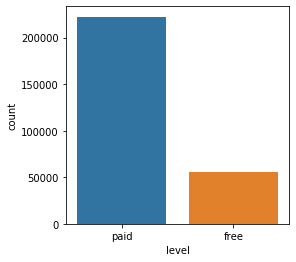

In [52]:
# Levels
set_plot_size(4, 4)
df = data.select('level').toPandas()
sb.countplot(data = df, x = 'level');

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



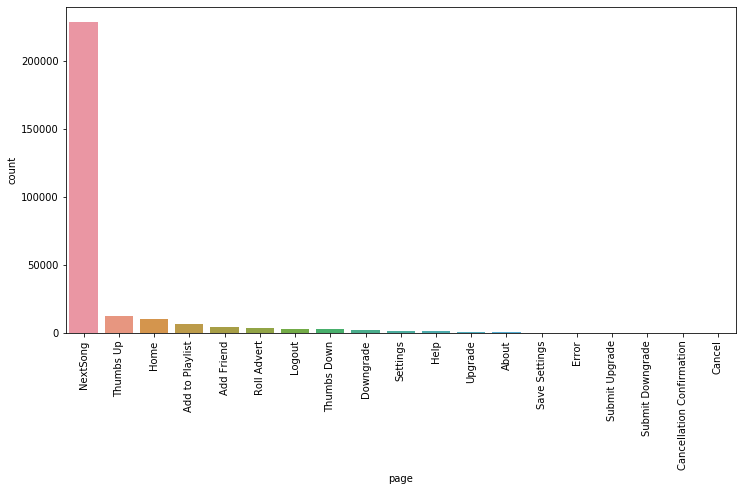

In [53]:
# Pages
data.select('page').dropDuplicates().sort('page').show(truncate=False)

set_plot_size(12, 6)
df = data.select('page').toPandas()
sb.countplot(data = df, x = 'page', order = df['page'].value_counts().index);
plt.xticks(rotation = 90);

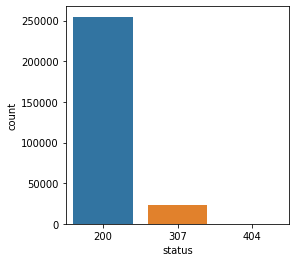

In [54]:
# Statuses 
set_plot_size(4, 4)
df = data.select('status').toPandas()
sb.countplot(data = df, x = 'status');

In [63]:
# Count of statuses
data.select('status').toPandas()['status'].value_counts()

200    254718
307     23184
404       252
Name: status, dtype: int64

Top 10 users with most logs:
+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
+------+-----+
only showing top 10 rows

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|              225|
|   mean|          1236.24|
| stddev|1329.531716432519|
|    min|                6|
|    max|             9632|
+-------+-----------------+



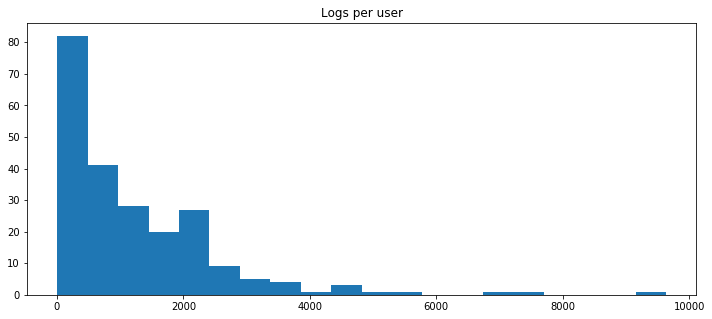

In [94]:
# Logs per user
print('Top 10 users with most logs:')
data.groupby('userId').count().sort(desc('count')).show(10)  
data.groupby('userId').count().describe('count').show()

set_plot_size(12, 5)
ax = plt.gca()
df = data.groupby('userId').count().toPandas()
plt.hist(data = df, x = 'count', bins = 20);
ax.set_title('Logs per user');

Top 10 users with most sessions:
+------+-----+
|userId|count|
+------+-----+
|    39|  107|
|    92|   86|
|300011|   76|
|200023|   76|
|   140|   71|
|300017|   63|
|300021|   58|
|    42|   47|
|    85|   41|
|    35|   38|
+------+-----+
only showing top 10 rows

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|               225|
|   mean|14.115555555555556|
| stddev|14.646884657111562|
|    min|                 1|
|    max|               107|
+-------+------------------+



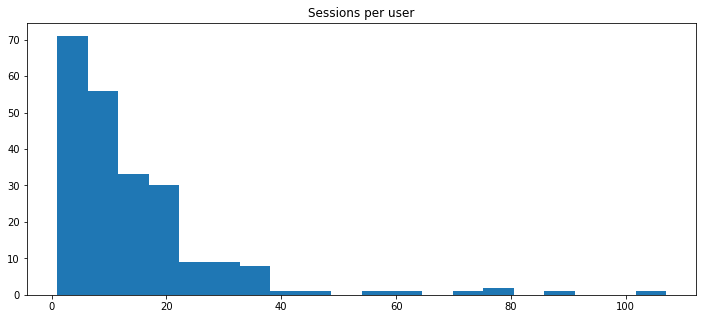

In [119]:
# Sessions per user
gdata = data.groupby('userId', 'sessionId').count() \
    .groupby('userId').count()

print('Top 10 users with most sessions:')
gdata.sort(desc('count')).show(10)
gdata.describe('count').show()

set_plot_size(12, 5)
ax = plt.gca()
df = gdata.toPandas()
plt.hist(data = df, x = 'count', bins = 20);
ax.set_title('Sessions per user');

count     2312.000000
mean      8964.957093
std      20525.300525
min          0.000000
25%         91.850000
50%        279.900000
75%       1120.075000
max      87739.100000
Name: duration, dtype: float64


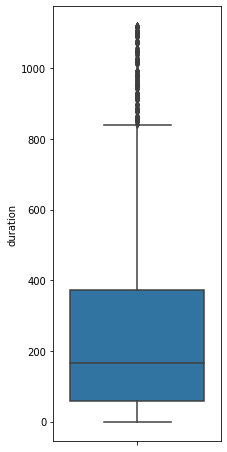

In [102]:
# Session duration (in minutes)
df = data.groupby('sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('sessionId', round(col('duration'), 1).alias('duration')) \
    .toPandas()

print(df.duration.describe())

# boxplot 75% of sessions
max_duration = 1121
set_plot_size(3, 8)
sb.boxplot(data = df[df.duration < 1121], y = 'duration');

In [116]:
# Session example with logs
data.where(data.sessionId == 319) \
    .select('tsDate', 'auth', 'level', 'page', 'status', 'song', 'artist', 'length') \
    .show()

+-------------------+---------+-----+---------+------+--------------------+--------------------+---------+
|             tsDate|     auth|level|     page|status|                song|              artist|   length|
+-------------------+---------+-----+---------+------+--------------------+--------------------+---------+
|2018-10-02 15:54:25|Logged In| free|     Home|   200|                null|                null|     null|
|2018-10-02 15:55:28|Logged In| free| NextSong|   200|Feel Good Inc (Al...|            Gorillaz|221.20444|
|2018-10-02 15:59:09|Logged In| free| NextSong|   200|Lullaby In Three/...|        Erin McKeown|249.88689|
|2018-10-02 16:03:18|Logged In| free| NextSong|   200|  Future Reflections|                MGMT|240.24771|
|2018-10-02 16:07:18|Logged In| free| NextSong|   200|Nemo Egg (Main Ti...|       Thomas Newman|  75.7024|
|2018-10-02 16:07:19|Logged In| free|Thumbs Up|   307|                null|                null|     null|
|2018-10-02 16:08:33|Logged In| free|

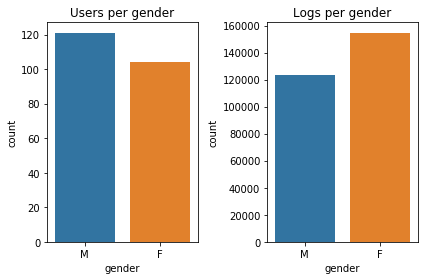

In [95]:
# Users & logs per gender
fig, axes = plt.subplots(nrows=1, ncols=2)

df_logs = data.select('gender').toPandas()
df_users = data.groupby('userId', 'gender').count().toPandas()

# users per gender
plt.subplot(1, 2, 1)
sb.countplot(data = df_users, x = 'gender', order = ['M','F']).set_title('Users per gender')

# logs per gender
plt.subplot(1, 2, 2)
sb.countplot(data = df_logs, x = 'gender', order = ['M','F']).set_title('Logs per gender');

fig.tight_layout();

### EDA on churned users

In [120]:
# Count churned users using Cancellation Confirmation evet
data.where(data.page == 'Cancellation Confirmation').dropDuplicates().count()

52

In [122]:
# Label churned users

# extract churned users
churned = data.where(data.page.isin(['Cancellation Confirmation'])) \
    .dropDuplicates() \
    .select('userId') \
    .collect()

# add new column using churned list
churned_uids = [x.userId for x in churned];
is_churn = udf(lambda x: 1 if x in churned_uids else 0, IntegerType())
data = data.withColumn('churn', is_churn('userId'))
data.take(3)

# check
data.where(data.churn == True).select('userId').dropDuplicates().count()

52

#### Churn vs. Gender

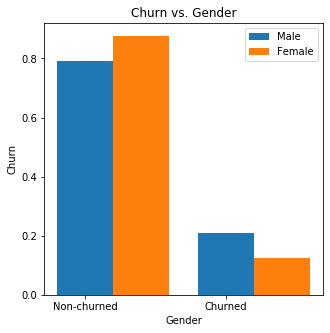

In [126]:
def calc_churn_share(row):
    if row['gender'] == 'M':
        return row['count']/row['M_total']
    else:
        return row['count']/row['F_total']

# prepare data
df = data \
    .groupby('gender', 'churn') \
    .count() \
    .withColumn('M_total', lit(data.where(data.gender == 'M').count())) \
    .withColumn('F_total', lit(data.where(data.gender == 'F').count())) \
    .toPandas()

df['churn_share'] = df.apply(lambda row: calc_churn_share(row), axis=1)
df1 = df[df.gender == 'M'].sort_values(by='churn')['churn_share']
df2 = df[df.gender == 'F'].sort_values(by='churn')['churn_share']

# plot
plt.figure(figsize = [5, 5])
width =0.4
labels = ['Non-churned', 'Churned']
plt.xticks(range(2), labels)
plt.xlabel('Gender')
plt.ylabel('Churn')
plt.bar(np.arange(len(df1)), df1, width=width)
plt.bar(np.arange(len(df2))+ width, df2, width=width)
ax = plt.gca()
ax.set_title('Churn vs. Gender');
plt.legend(['Male', 'Female'], loc=1)
plt.show()

#### Churn vs. Level

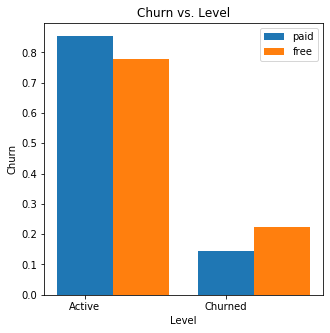

In [127]:
def calc_churn_share(row):
    if row['level'] == 'paid':
        return row['count']/row['paid_total']
    else:
        return row['count']/row['free_total']

# prepare data
df = data \
    .groupby('level', 'churn') \
    .count() \
    .withColumn('paid_total', lit(data.where(data.level == 'paid').count())) \
    .withColumn('free_total', lit(data.where(data.level == 'free').count())) \
    .toPandas()

df['churn_share'] = df.apply(lambda row: calc_churn_share(row), axis=1)
df1 = df[df.level == 'paid'].sort_values(by='churn')['churn_share']
df2 = df[df.level == 'free'].sort_values(by='churn')['churn_share']

# plot
plt.figure(figsize = [5, 5])
width = 0.4
labels = ['Active', 'Churned']
plt.xticks(range(2), labels)
plt.xlabel('Level')
plt.ylabel('Churn')
plt.bar(np.arange(len(df1)), df1, width=width)
plt.bar(np.arange(len(df2))+width, df2, width=width)
ax = plt.gca()
ax.set_title('Churn vs. Level');
plt.legend(['paid', 'free'], loc=1)
plt.show()

#### Churn vs. Location (state)

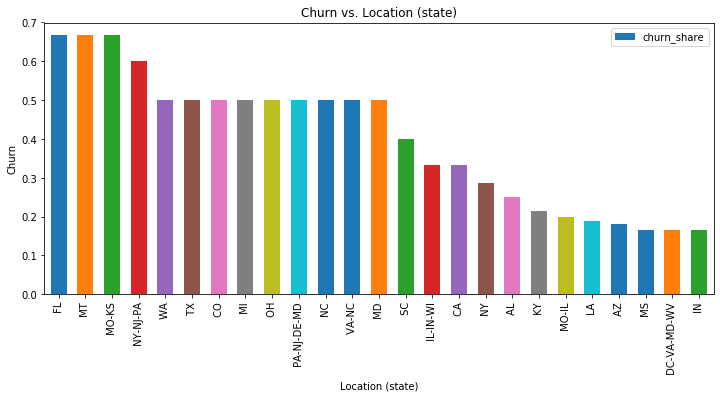

In [128]:
df = data \
    .select('churn', 'state', 'userId') \
    .dropDuplicates() \
    .groupby('churn', 'state') \
    .count() \
    .toPandas().set_index('state')

states = df[df.churn == 0].join(df[df.churn == 1], lsuffix='_active', rsuffix='_churn') \
                          .dropna()[['count_active', 'count_churn']]
states.count_churn = states.count_churn.astype(int)
states['churn_share'] = states['count_churn']/(states['count_churn'] + states['count_active'])

states.sort_values(by='churn_share', ascending=False) \
    .plot(x = states.index, y = 'churn_share', kind='bar', figsize = (12, 5), width=0.6);
ax = plt.gca()
ax.set_title('Churn vs. Location (state)');
plt.xlabel('Location (state)')
plt.ylabel('Churn')
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.